In [1]:
# Basisc square wave: SX-->T1;  flat band --> T2;  T1 + T2 = T
from signal import signal
from scipy.special import jn_zeros
from itertools import combinations

def drive(t, args):
    w = args['omega']
    g = args['g']
    
    # Example: cos²(wt) function
    signl = g - g * np.cos(w/2  * t)**2
    return signl


# HAMILTONIAN   

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta
 
def position_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    Jvalue = args['J']
    beta = args['beta']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H01, H02, H11 = empt,  empt, empt
    
    # for i in range(N-1):
    #     id = qeye(2**i)    
    #     dim11 = N-2-i
    #     id1 = qeye(2**dim11)
    #     H01 = H01 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())
        
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H01 = H01 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full())\
            * j_ij(Jvalue, i,j, beta)

        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sx,id1)).full()) * (1-er)
        
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H01, H02, H11

# FLOQUET ANALYSIS

def floquet_return_position(args):
    N  =  args['N']
    er = args['er']
    H01, H02, H11 = position_hamiltonian(args)
    H = [H01,[H02, drive]]

    T = 2 * np.pi/args['omega']
    f_modes_0, f_energies = floquet_modes(H, T, args)
    return f_energies

# MAGNETIZATION
def magnetization_position(args):      
    N  =  args['N']
    er = args['er']
    H01, H02, H11 = position_hamiltonian(args)
    H = [H01,[H02, drive]]

    grket = basis(2**N,0)
    times = args['times']
    data = mesolve(H, grket, times, [], [H11/N], args = args)
    return data.expect

print("Functions defined")

Functions defined


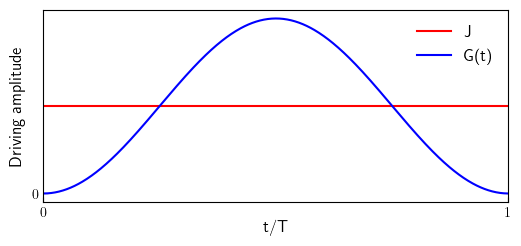

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.special import jn_zeros


plt.rcParams.update({"figure.figsize": (6, 2.5), "text.usetex": True, "font.size": 20})

w = 20
T = 2 * np.pi/w
times = np.linspace(0, 1*T, 600)
duty = 0.5

J = 1
g = w/2

params = {'omega': w, 'J': J , 'g': g}  

plt.axhline(y = 5, color = 'red', label = r'J')
plt.plot(times/T, np.array([drive(t, params) for t in times]), color = 'blue', label = r'G(t)')

plt.tick_params(axis='both', which='both', labelsize=10)
plt.xlabel('t/T', fontsize = 12, labelpad=0)
plt.ylabel(r'Driving amplitude', fontsize = 12, labelpad=5)
plt.tick_params(which='both', direction='in')
plt.xticks([0,1])
plt.yticks([0])
#plt.legend(frameon = True,  fontsize =15, ncol =3, loc = 'center', bbox_to_anchor = (0.5, 1.15))
plt.legend(frameon = False,  fontsize =12, ncol =1, loc = 'upper right')
#plt.yticks([])
plt.xlim(0,1)
plt.savefig("continuous_flip_drive.pdf", bbox_inches = 'tight')

plt.show()

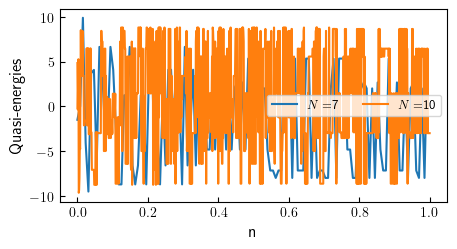

In [9]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

plt.rcParams.update({"figure.figsize": (5, 2.5), "text.usetex": True, "font.size": 12})

Ns = [7, 10]
omega = 20
w = omega
J = 1
g = w/2
er = 0.0

beta = 0.0

T = 2 * np.pi/omega
time_period = 4
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'times':times, 'N':N, 'beta':beta, 'J':J, 'g':g} for N in Ns]

data_floquet = p.map(floquet_return_position, params)

for i, N in enumerate(Ns):
    plt.plot(np.linspace(0, len(data_floquet[i])-1, len(data_floquet[i]))/len(data_floquet[i]), data_floquet[i], label = r'$N=$'+str(N))

plt.xlabel('n')
plt.ylabel(r'Quasi-energies')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =9, ncol = 2)
#plt.xlim(1490, 1500)
#plt.ylim(-0.1, 0.1)

#plt.axhline(y = 1, color = 'black', lw = 0.5)
#plt.axhline(y = -0.5, color = 'black', lw = 0.5)

#plt.savefig("pure_flatband.pdf", bbox_inches = 'tight')
plt.show()

## DTC without Rotational Error

In [3]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

Ns = [8, 10, 11, 12]
omega = 20
w = omega
beta = float('inf')

T = 2 * np.pi/omega
time_period = 2500
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

J = 0.2/T
g = w/2

er = 0.0

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'times':times, 'N':N,'beta':beta, 'J':J, 'g':g} for N in Ns]

data_tfim_p_fb = np.array(p.map(magnetization_position, params))


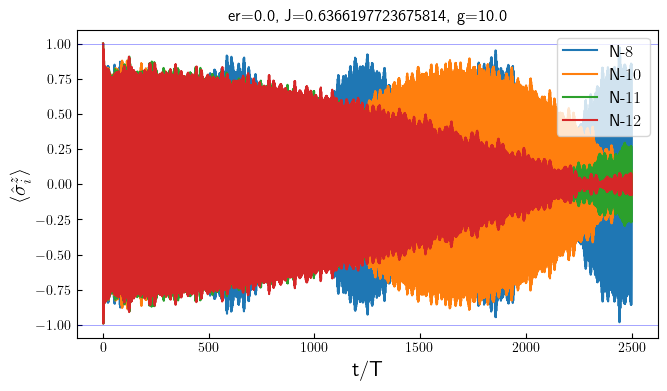

In [4]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})

# DATA PLOTTING

for i, N in enumerate(Ns):
    plt.plot(times/T, data_tfim_p_fb[i][0], label =fr"N-${N}$")

plt.xlabel('t/T')
plt.ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
plt.title(fr"er={er}, J={J}, g={g}", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =12)
#plt.xlim(1490, 1500)
#plt.ylim(0.99, 1.01)

plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

#for i in np.arange(0, int(times[-1]/T)+1, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

#plt.savefig(fr"mag_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()

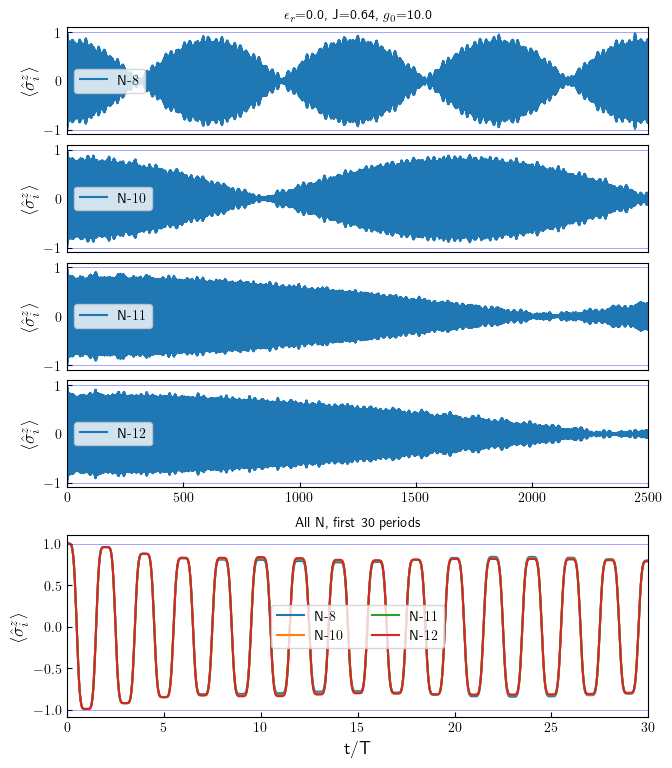

In [5]:
plt.rcParams.update({"text.usetex": True, "font.size": 13})

n_N = len(Ns)
nrows = n_N + 1

fig, axs = plt.subplots(nrows, 1, figsize=(7.5, 1.5 * nrows))
plt.subplots_adjust(hspace=0.1, wspace=0.0)

# Increase space before the last subplot
pos = axs[-1].get_position()
new_pos = [pos.x0, pos.y0 - 0.15, pos.width, pos.height + 0.1]
axs[-1].set_position(new_pos)

# Plot each N in its own subplot (full time)
for i, N in enumerate(Ns):
    axs[i].plot(times/T, data_tfim_p_fb[i][0], label=fr"N-${N}$")
    axs[i].set_ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
    axs[i].set_xticks([])
    axs[i].tick_params(axis='both', which='both', labelsize=10)
    axs[i].tick_params(which='both', direction='in')
    axs[i].legend(frameon=True, fontsize=10, ncol=1, loc='center left')
    axs[i].axhline(y=1, color='blue', alpha=0.5, lw=0.5)
    axs[i].axhline(y=-1, color='blue', alpha=0.5, lw=0.5)
    axs[i].set_xlim(0, times[-1]/T)

axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, $g_0$={g}", fontsize=10)
axs[3].set_xticks(np.arange(0, int(times[-1]/T)+1, 500))

# Last subplot: all N up to max_period
max_period = 30
mask_50 = times/T <= max_period
for i, N in enumerate(Ns):
    axs[-1].plot((times/T)[mask_50], data_tfim_p_fb[i][0][mask_50], label=fr"N-${N}$")
axs[-1].set_xlabel('t/T')
axs[-1].set_ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
axs[-1].set_title(f"All N, first {max_period} periods", fontsize=10)
axs[-1].tick_params(axis='both', which='both', labelsize=10)
axs[-1].tick_params(which='both', direction='in')
axs[-1].legend(frameon=True, fontsize=10, ncol=2)
axs[-1].axhline(y=1, color='blue', alpha=0.5, lw=0.5)
axs[-1].axhline(y=-1, color='blue', alpha=0.5, lw=0.5)
axs[-1].set_xlim(0, max_period)

plt.savefig(fr"time_mag_$\epsilon_r${er:1.2f}_J{J:1.2f}_g{g:2.1f}_allN.pdf", bbox_inches = 'tight')

plt.show()


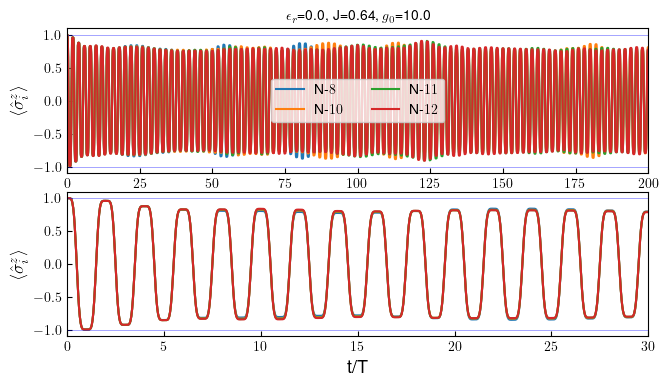

In [ ]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 13})

# DATA PLOTTING

fig, axs = plt.subplots(2, 1, figsize=(7.5, 4))
plt.subplots_adjust(hspace=0.13, wspace=0.0)

# Full time period plot (original)
for i, N in enumerate(Ns):
    axs[0].plot(times/T, data_tfim_p_fb[i][0], label =fr"N-${N}$")
#axs[0].set_xlabel('t/T')
axs[0].set_ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, $g_0$={g}", fontsize = 10)
axs[0].tick_params(axis='both', which='both', labelsize=10)
axs[0].tick_params(which='both', direction='in')
axs[0].legend(frameon = True,  fontsize =10, ncol = 2, loc = 'center')
axs[0].axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
axs[0].axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)
axs[0].set_xlim(0, times[-1]/T)

# Up to 50 time periods
max_period = 30
mask_50 = times/T <= max_period
for i, N in enumerate(Ns):
    axs[1].plot((times/T)[mask_50], data_tfim_p_fb[i][0][mask_50], label =fr"N-${N}$")
axs[1].set_xlabel('t/T')
axs[1].set_ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
#axs[1].set_title(fr"er={er}, J={J}, g={g} (First 50 periods)", fontsize = 12)
axs[1].tick_params(axis='both', which='both', labelsize=10)
axs[1].tick_params(which='both', direction='in')
#axs[1].legend(frameon = True,  fontsize =12)
axs[1].axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
axs[1].axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)
axs[1].set_xlim(0, max_period)

plt.savefig(fr"DTC_continuous_er={er}_J={J:1.2f}_g={g:2f}.pdf", bbox_inches = 'tight')

plt.show()

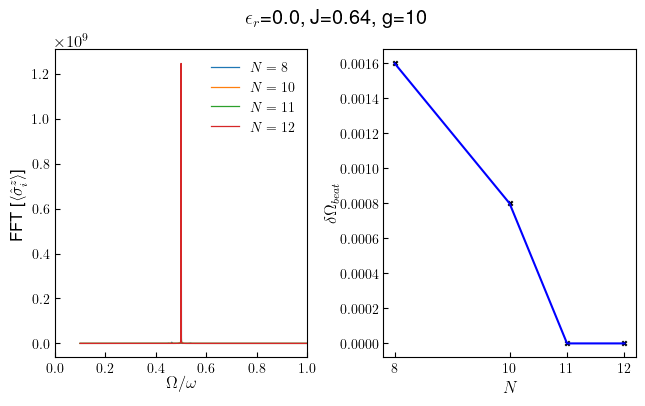

In [7]:
# Find out beats from drive functions for each N from data_tfim_p_fb datafile


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

fig, axs = plt.subplots(1,2)
plt.subplots_adjust(hspace=0.0, wspace=0.3)

#-------  FFT   ----------------------------------------------------------------       
freq_threshold = 0.1
btfr, ers = [], [] 


for i, N in enumerate(Ns):
    mz  = data_tfim_p_fb[i][0]

   
    frequencies = T * np.fft.fftfreq(mz.size, d = times[-1]/len(times))
    fft_values = np.fft.fft(mz - np.average(mz))
    
    #mask = frequencies > freq_threshold
    mask = (frequencies > freq_threshold) & (frequencies <1.0)
    y = np.abs(fft_values[mask])**2
    x = frequencies[mask]

    line, = axs[0].plot(x, y, linewidth=0.9, label = fr'$N={N}$')           

    #-------  Find FFT Peaks and Beats frequencies   --------------------------
    
    #peak_idx, peak_props = find_peaks(y, prominence = 5, distance = None, height = 1.0e10)
    peak_idx, peak_props = find_peaks(y, prominence = 1)
    peak_pos = x[peak_idx]                     

    # Plot stars at the peaks
    #axs[0].plot(peak_pos, y[peak_idx], 'x', markersize=10, label='Peaks' if i == 0 else "")
    
    peaks_before = peak_pos[peak_pos <= 0.5]
    before_proms = peak_props['prominences'][peak_pos <= 0.5]
    if before_proms.size > 0:
        most_prominent_idx = np.argmax(before_proms)
        prominent_freq_before = peaks_before[most_prominent_idx]
    else:
        prominent_freq_before = np.nan  # or continue, or set to 0

    peaks_after = peak_pos[peak_pos >= 0.5]
    after_proms = peak_props['prominences'][peak_pos >= 0.5]
    if after_proms.size > 0:
        most_prominent_idx = np.argmax(after_proms)
        prominent_freq_after = peaks_after[most_prominent_idx]
    else:
        prominent_freq_after = np.nan  # or continue, or set to 0

    if not np.isnan(prominent_freq_before) and not np.isnan(prominent_freq_after):
        beat_freq = np.abs(prominent_freq_after - prominent_freq_before)
        btfr.append(beat_freq)
    else:
        btfr.append(np.nan)

axs[1].plot(Ns, btfr, color = 'blue')
axs[1].scatter(Ns, btfr, s = 10, marker = 'x', color = 'black')

axs[1].set_xlabel(r'$N$')
axs[1].set_ylabel(r'$\delta\Omega_{beat}$', labelpad = 0)
axs[1].set_xticks(Ns)
#axs[1].set_yscale('log')
axs[1].legend(frameon = False, fontsize = 10)
axs[1].tick_params(axis='both', which='both', labelsize=10)
axs[1].tick_params(which='both', direction='in')

axs[0].set_xlabel(r'$\Omega/\omega$', labelpad = 0)
axs[0].set_ylabel(r'FFT [$\langle \hat{\sigma}^z_i \rangle$]')
axs[0].set_xlim(0, 1)
#axs[0].set_xlim(0.48, 0.52)
#axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='both', labelsize=10)
axs[0].tick_params(which='both', direction='in')
axs[0].legend(frameon = False, fontsize = 10)
#axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")
plt.suptitle(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")

plt.savefig(fr"DTC_mag_fft_beat_er={er}_J={J}_g={g}.pdf", bbox_inches='tight')

plt.show()

## Now in presence of finite rotational error

In [8]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

Ns = [8, 10, 11, 12]
omega = 20
w = omega
beta = float('inf')

T = 2 * np.pi/omega
time_period = 2500
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

J = 0.2/T
g = w/2

er = 0.03

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'times':times, 'N':N,'beta':beta, 'J':J, 'g':g} for N in Ns]

data_tfim_p_fb = np.array(p.map(magnetization_position, params))


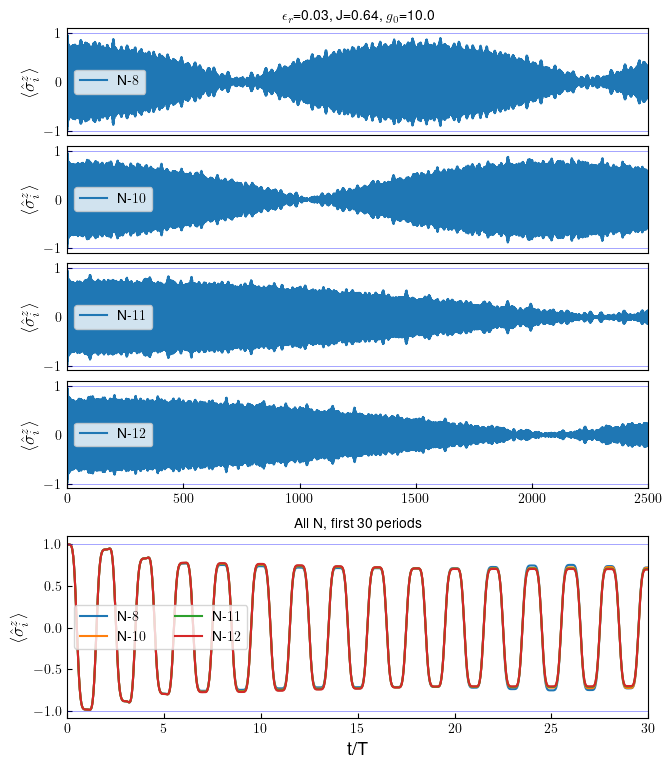

In [9]:
plt.rcParams.update({"text.usetex": True, "font.size": 13})

n_N = len(Ns)
nrows = n_N + 1

fig, axs = plt.subplots(nrows, 1, figsize=(7.5, 1.5 * nrows))
plt.subplots_adjust(hspace=0.1, wspace=0.0)

# Increase space before the last subplot
pos = axs[-1].get_position()
new_pos = [pos.x0, pos.y0 - 0.15, pos.width, pos.height + 0.1]
axs[-1].set_position(new_pos)

# Plot each N in its own subplot (full time)
for i, N in enumerate(Ns):
    axs[i].plot(times/T, data_tfim_p_fb[i][0], label=fr"N-${N}$")
    axs[i].set_ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
    axs[i].set_xticks([])
    axs[i].tick_params(axis='both', which='both', labelsize=10)
    axs[i].tick_params(which='both', direction='in')
    axs[i].legend(frameon=True, fontsize=10, ncol=1, loc='center left')
    axs[i].axhline(y=1, color='blue', alpha=0.5, lw=0.5)
    axs[i].axhline(y=-1, color='blue', alpha=0.5, lw=0.5)
    axs[i].set_xlim(0, times[-1]/T)

axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, $g_0$={g}", fontsize=10)
axs[3].set_xticks(np.arange(0, int(times[-1]/T)+1, 500))

# Last subplot: all N up to max_period
max_period = 30
mask_50 = times/T <= max_period
for i, N in enumerate(Ns):
    axs[-1].plot((times/T)[mask_50], data_tfim_p_fb[i][0][mask_50], label=fr"N-${N}$")
axs[-1].set_xlabel('t/T')
axs[-1].set_ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
axs[-1].set_title(f"All N, first {max_period} periods", fontsize=10)
axs[-1].tick_params(axis='both', which='both', labelsize=10)
axs[-1].tick_params(which='both', direction='in')
axs[-1].legend(frameon=True, fontsize=10, ncol=2)
axs[-1].axhline(y=1, color='blue', alpha=0.5, lw=0.5)
axs[-1].axhline(y=-1, color='blue', alpha=0.5, lw=0.5)
axs[-1].set_xlim(0, max_period)

plt.savefig(fr"time_mag_$\epsilon_r${er:1.2f}_J{J:1.2f}_g{g:2.1f}_allN.pdf", bbox_inches = 'tight')

plt.show()


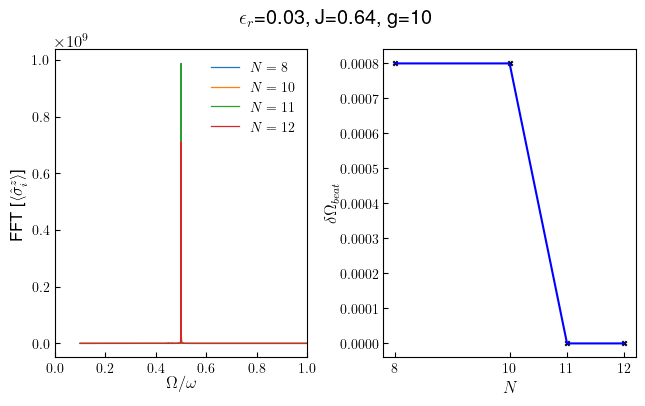

In [10]:
# Find out beats from drive functions for each N from data_tfim_p_fb datafile


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

fig, axs = plt.subplots(1,2)
plt.subplots_adjust(hspace=0.0, wspace=0.3)

#-------  FFT   ----------------------------------------------------------------       
freq_threshold = 0.1
btfr, ers = [], [] 


for i, N in enumerate(Ns):
    mz  = data_tfim_p_fb[i][0]

   
    frequencies = T * np.fft.fftfreq(mz.size, d = times[-1]/len(times))
    fft_values = np.fft.fft(mz - np.average(mz))
    
    #mask = frequencies > freq_threshold
    mask = (frequencies > freq_threshold) & (frequencies <1.0)
    y = np.abs(fft_values[mask])**2
    x = frequencies[mask]

    line, = axs[0].plot(x, y, linewidth=0.9, label = fr'$N={N}$')           

    #-------  Find FFT Peaks and Beats frequencies   --------------------------
    
    #peak_idx, peak_props = find_peaks(y, prominence = 5, distance = None, height = 1.0e10)
    peak_idx, peak_props = find_peaks(y, prominence = 1)
    peak_pos = x[peak_idx]                     

    # Plot stars at the peaks
    #axs[0].plot(peak_pos, y[peak_idx], 'x', markersize=10, label='Peaks' if i == 0 else "")
    
    peaks_before = peak_pos[peak_pos <= 0.5]
    before_proms = peak_props['prominences'][peak_pos <= 0.5]
    if before_proms.size > 0:
        most_prominent_idx = np.argmax(before_proms)
        prominent_freq_before = peaks_before[most_prominent_idx]
    else:
        prominent_freq_before = np.nan  # or continue, or set to 0

    peaks_after = peak_pos[peak_pos >= 0.5]
    after_proms = peak_props['prominences'][peak_pos >= 0.5]
    if after_proms.size > 0:
        most_prominent_idx = np.argmax(after_proms)
        prominent_freq_after = peaks_after[most_prominent_idx]
    else:
        prominent_freq_after = np.nan  # or continue, or set to 0

    if not np.isnan(prominent_freq_before) and not np.isnan(prominent_freq_after):
        beat_freq = np.abs(prominent_freq_after - prominent_freq_before)
        btfr.append(beat_freq)
    else:
        btfr.append(np.nan)

axs[1].plot(Ns, btfr, color = 'blue')
axs[1].scatter(Ns, btfr, s = 10, marker = 'x', color = 'black')

axs[1].set_xlabel(r'$N$')
axs[1].set_ylabel(r'$\delta\Omega_{beat}$', labelpad = 0)
axs[1].set_xticks(Ns)
#axs[1].set_yscale('log')
axs[1].legend(frameon = False, fontsize = 10)
axs[1].tick_params(axis='both', which='both', labelsize=10)
axs[1].tick_params(which='both', direction='in')

axs[0].set_xlabel(r'$\Omega/\omega$', labelpad = 0)
axs[0].set_ylabel(r'FFT [$\langle \hat{\sigma}^z_i \rangle$]')
axs[0].set_xlim(0, 1)
#axs[0].set_xlim(0.48, 0.52)
#axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='both', labelsize=10)
axs[0].tick_params(which='both', direction='in')
axs[0].legend(frameon = False, fontsize = 10)
#axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")
plt.suptitle(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")

plt.savefig(fr"DTC_mag_fft_beat_er={er}_J={J}_g={g}.pdf", bbox_inches='tight')

plt.show()